# Tutorial 3: Distance-Dependent Connectivity Patterns

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/braintools/blob/main/docs/init_tutorial_03_distance_profiles.ipynb)

This tutorial explores distance-dependent connectivity patterns that are fundamental to spatial neural networks. In biological neural systems, connection probability and strength often depend on the physical distance between neurons.

## Topics Covered

1. **Distance profiles** for spatial neural connectivity
2. **Basic profiles**: Gaussian, Exponential, PowerLaw, Linear, Step
3. **Advanced profiles**: Sigmoid, DoG, Logistic, Bimodal, MexicanHat
4. **Profile composition**: arithmetic operations, clipping, transformations
5. **Pipe operator** for functional composition
6. **Real-world neuroscience** applications

## Installation and Setup

In [1]:
# Install braintools if needed
# !pip install braintools brainunit matplotlib numpy scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import brainunit as u
from braintools import init

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

## 1. Introduction to Distance-Dependent Connectivity

### Biological Motivation

In the brain, neurons are spatially organized, and their connectivity follows specific patterns:

- **Local connectivity**: Neurons close together are more likely to connect
- **Distance decay**: Connection probability decreases with distance
- **Lateral inhibition**: Nearby neurons may inhibit slightly distant ones
- **Long-range connections**: Some neurons connect across large distances

### Distance Profiles

A **distance profile** defines how connection properties vary with spatial distance:

```python
probability = profile.probability(distances)
weight_scaling = profile.weight_scaling(distances)
```

### Key Concepts

1. **Connection probability**: Likelihood of forming a connection
2. **Weight scaling**: Strength modulation based on distance
3. **Spatial units**: Using physical distances (μm, mm, etc.)
4. **Profile composition**: Combining multiple patterns

In [3]:
# Helper function to visualize profiles
def visualize_profile(profile, max_distance=200, title="Distance Profile", unit=u.um):
    """
    Visualize a distance profile.
    """
    distances = np.linspace(0, max_distance, 500) * unit
    probabilities = profile.probability(distances)
    weights = profile.weight_scaling(distances)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Probability
    axes[0].plot(distances.mantissa, probabilities, linewidth=2)
    axes[0].fill_between(distances.mantissa, probabilities, alpha=0.3)
    axes[0].set_xlabel(f'Distance ({unit})')
    axes[0].set_ylabel('Connection Probability')
    axes[0].set_title(f'{title} - Probability')
    axes[0].grid(alpha=0.3)
    axes[0].set_ylim([0, 1.1])
    
    # Weight scaling
    axes[1].plot(distances.mantissa, weights, linewidth=2, color='orange')
    axes[1].fill_between(distances.mantissa, weights, alpha=0.3, color='orange')
    axes[1].set_xlabel(f'Distance ({unit})')
    axes[1].set_ylabel('Weight Scaling Factor')
    axes[1].set_title(f'{title} - Weight Scaling')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return distances, probabilities, weights

## 2. Basic Distance Profiles

### 2.1 Gaussian Profile

The **Gaussian profile** creates bell-shaped connectivity with peak at distance 0:

$$p(d) = \exp\left(-\frac{d^2}{2\sigma^2}\right)$$

**Parameters:**
- `sigma`: Standard deviation (controls spread)
- `max_distance`: Optional cutoff distance

**Use cases:**
- Local excitatory connections
- Smooth distance decay
- Cortical columns

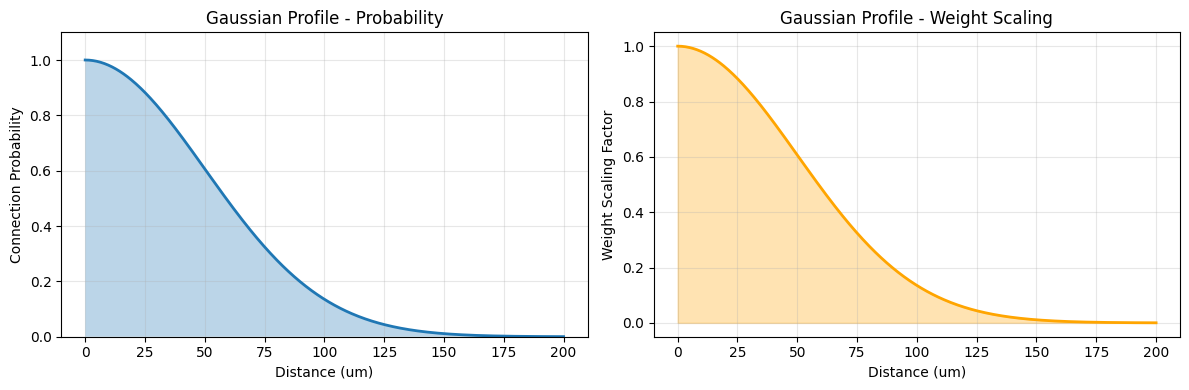

Gaussian Profile Properties:
  Probability at 0 μm: 1.000
  Probability at 50 μm (1σ): 0.134
  Half-width at half-max: ~58.9 μm


In [5]:
# Create Gaussian profile
gaussian = init.GaussianProfile(
    sigma=50.0 * u.um,
    max_distance=200.0 * u.um
)

distances, probs, weights = visualize_profile(gaussian, title="Gaussian Profile")

print(f"Gaussian Profile Properties:")
print(f"  Probability at 0 μm: {probs[0]:.3f}")
print(f"  Probability at 50 μm (1σ): {probs[250]:.3f}")
print(f"  Half-width at half-max: ~{50 * np.sqrt(2 * np.log(2)):.1f} μm")

### Effect of Sigma Parameter

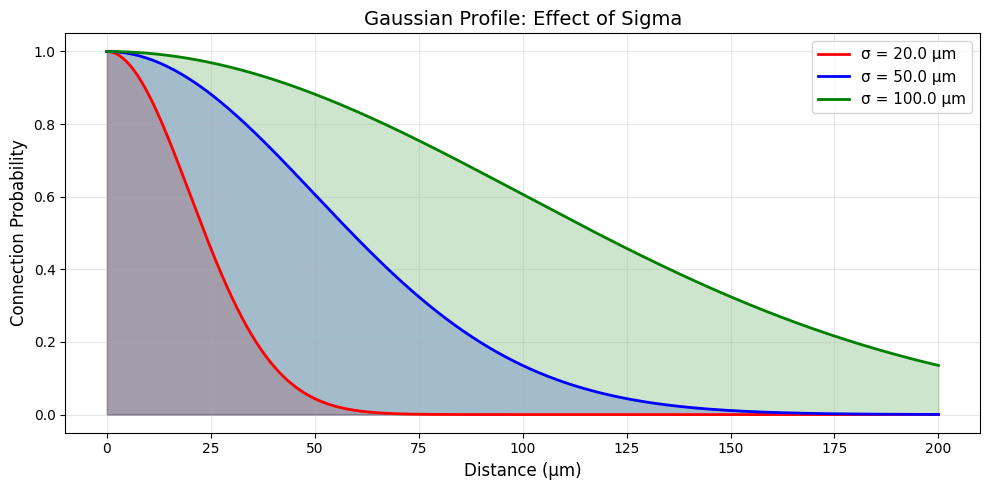

💡 Larger sigma → broader connectivity


In [6]:
# Compare different sigma values
sigmas = [20.0, 50.0, 100.0]
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(0, 200, 500) * u.um

for sigma, color in zip(sigmas, colors):
    profile = init.GaussianProfile(sigma=sigma * u.um)
    probs = profile.probability(distances)
    ax.plot(distances.mantissa, probs, linewidth=2, label=f'σ = {sigma} μm', color=color)
    ax.fill_between(distances.mantissa, probs, alpha=0.2, color=color)

ax.set_xlabel('Distance (μm)', fontsize=12)
ax.set_ylabel('Connection Probability', fontsize=12)
ax.set_title('Gaussian Profile: Effect of Sigma', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Larger sigma → broader connectivity")

### 2.2 Exponential Profile

The **Exponential profile** creates monotonic decay:

$$p(d) = \exp\left(-\frac{d}{\lambda}\right)$$

**Parameters:**
- `decay_constant` (λ): Distance constant for decay
- `max_distance`: Optional cutoff

**Use cases:**
- Long-range connections
- Axonal arbor patterns
- Distance-dependent decay

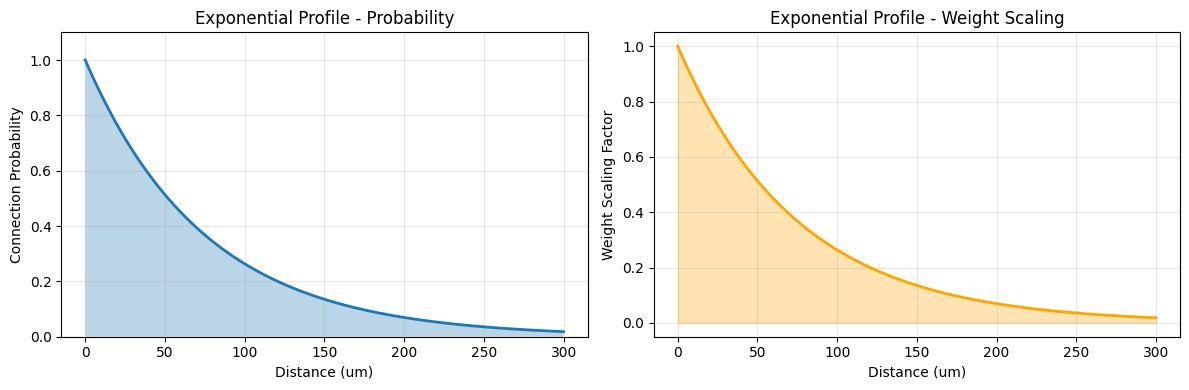


Exponential Profile Properties:
  Probability at 0: 1.000
  Probability at λ (75 μm): 0.368 ≈ 0.368
  Probability at 2λ (150 μm): 0.135 ≈ 0.135
  Half-distance: 52.0 μm


In [7]:
# Create Exponential profile
exponential = init.ExponentialProfile(
    decay_constant=75.0 * u.um,
    max_distance=300.0 * u.um
)

visualize_profile(exponential, max_distance=300, title="Exponential Profile")

print(f"\nExponential Profile Properties:")
print(f"  Probability at 0: 1.000")
print(f"  Probability at λ (75 μm): {np.exp(-1):.3f} ≈ 0.368")
print(f"  Probability at 2λ (150 μm): {np.exp(-2):.3f} ≈ 0.135")
print(f"  Half-distance: {75 * np.log(2):.1f} μm")

### Gaussian vs Exponential

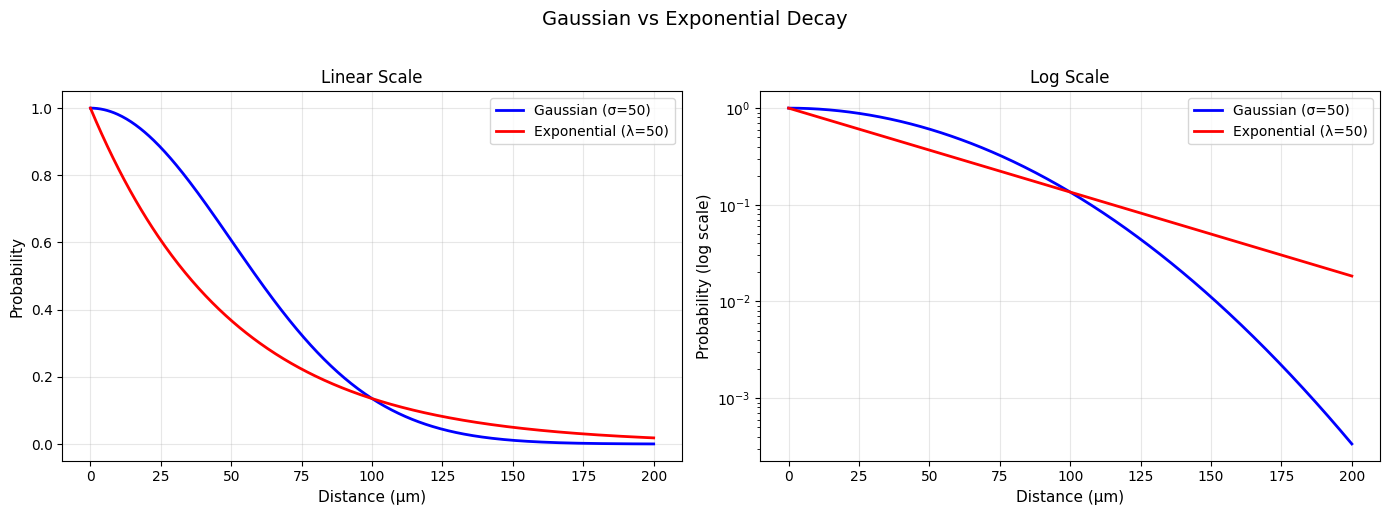


📊 Key differences:
  Gaussian: Symmetric, bell-shaped, faster tail decay
  Exponential: Monotonic, linear in log-space, heavier tails


In [8]:
# Compare Gaussian and Exponential
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

distances = np.linspace(0, 200, 500) * u.um

gaussian_prof = init.GaussianProfile(sigma=50.0 * u.um)
exponential_prof = init.ExponentialProfile(decay_constant=50.0 * u.um)

gauss_prob = gaussian_prof.probability(distances)
exp_prob = exponential_prof.probability(distances)

# Linear scale
axes[0].plot(distances.mantissa, gauss_prob, linewidth=2, label='Gaussian (σ=50)', color='blue')
axes[0].plot(distances.mantissa, exp_prob, linewidth=2, label='Exponential (λ=50)', color='red')
axes[0].set_xlabel('Distance (μm)', fontsize=11)
axes[0].set_ylabel('Probability', fontsize=11)
axes[0].set_title('Linear Scale', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log scale
axes[1].semilogy(distances.mantissa, gauss_prob, linewidth=2, label='Gaussian (σ=50)', color='blue')
axes[1].semilogy(distances.mantissa, exp_prob, linewidth=2, label='Exponential (λ=50)', color='red')
axes[1].set_xlabel('Distance (μm)', fontsize=11)
axes[1].set_ylabel('Probability (log scale)', fontsize=11)
axes[1].set_title('Log Scale', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Gaussian vs Exponential Decay', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Key differences:")
print("  Gaussian: Symmetric, bell-shaped, faster tail decay")
print("  Exponential: Monotonic, linear in log-space, heavier tails")

### 2.3 Power Law Profile

The **Power Law profile** follows:

$$p(d) = d^{-\alpha}$$

**Parameters:**
- `exponent` (α): Power law exponent
- `min_distance`: Avoid division by zero
- `max_distance`: Optional cutoff

**Use cases:**
- Scale-free networks
- Long-range connections
- Brain-wide connectivity

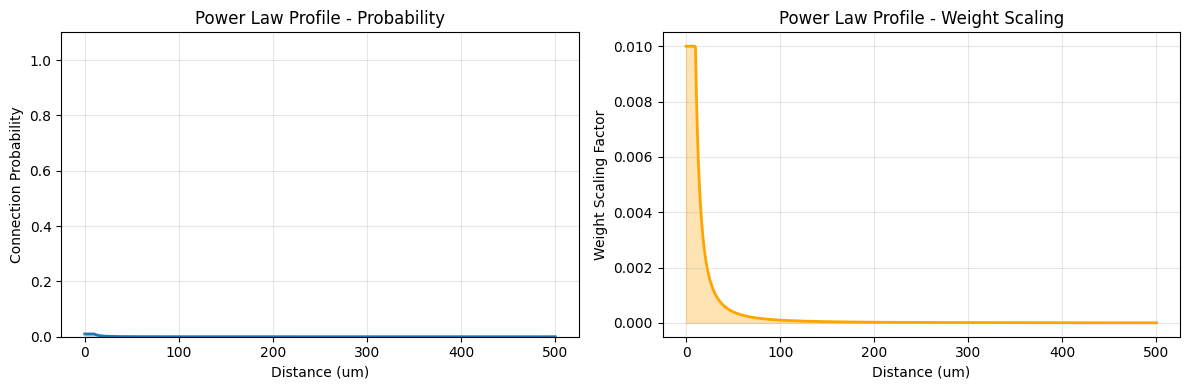

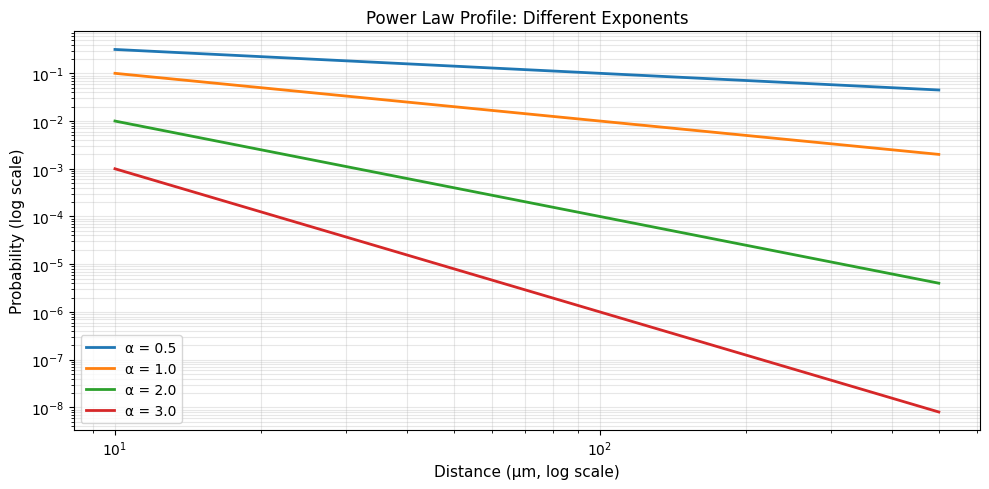


💡 Power law properties:
  - Linear in log-log space
  - Larger α → steeper decay
  - Heavy tails (scale-free)


In [9]:
# Create Power Law profile
powerlaw = init.PowerLawProfile(
    exponent=2.0,
    min_distance=10.0 * u.um,
    max_distance=500.0 * u.um
)

visualize_profile(powerlaw, max_distance=500, title="Power Law Profile")

# Compare different exponents
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(10, 500, 500) * u.um
exponents = [0.5, 1.0, 2.0, 3.0]

for exp in exponents:
    profile = init.PowerLawProfile(exponent=exp, min_distance=10.0 * u.um)
    probs = profile.probability(distances)
    ax.loglog(distances.mantissa, probs, linewidth=2, label=f'α = {exp}')

ax.set_xlabel('Distance (μm, log scale)', fontsize=11)
ax.set_ylabel('Probability (log scale)', fontsize=11)
ax.set_title('Power Law Profile: Different Exponents', fontsize=12)
ax.legend()
ax.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\n💡 Power law properties:")
print("  - Linear in log-log space")
print("  - Larger α → steeper decay")
print("  - Heavy tails (scale-free)")

### 2.4 Linear Profile

The **Linear profile** decreases linearly:

$$p(d) = \max\left(0, 1 - \frac{d}{d_{max}}\right)$$

**Parameters:**
- `max_distance`: Distance at which probability reaches 0

**Use cases:**
- Simple distance decay
- Hard cutoffs
- Piecewise connectivity

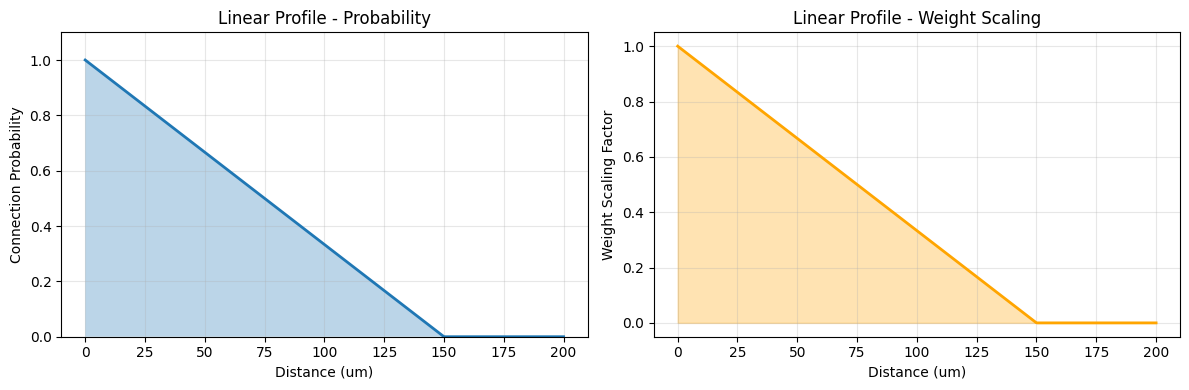


Linear Profile Properties:
  - Simplest decay pattern
  - Hard cutoff at max_distance
  - Uniform rate of decay


In [10]:
# Create Linear profile
linear = init.LinearProfile(max_distance=150.0 * u.um)

visualize_profile(linear, max_distance=200, title="Linear Profile")

print("\nLinear Profile Properties:")
print("  - Simplest decay pattern")
print("  - Hard cutoff at max_distance")
print("  - Uniform rate of decay")

### 2.5 Step Profile

The **Step profile** creates binary connectivity regions:

$$p(d) = \begin{cases} 
p_{in} & d \leq d_{threshold} \\
p_{out} & d > d_{threshold}
\end{cases}$$

**Parameters:**
- `threshold`: Distance threshold
- `inside_prob`: Probability inside threshold
- `outside_prob`: Probability outside threshold

**Use cases:**
- Local vs long-range separation
- Two-population connectivity
- Binary spatial domains

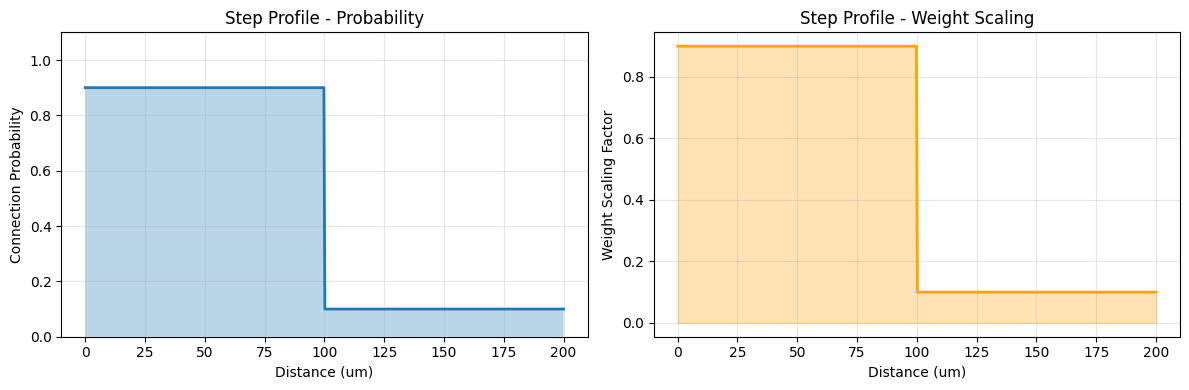

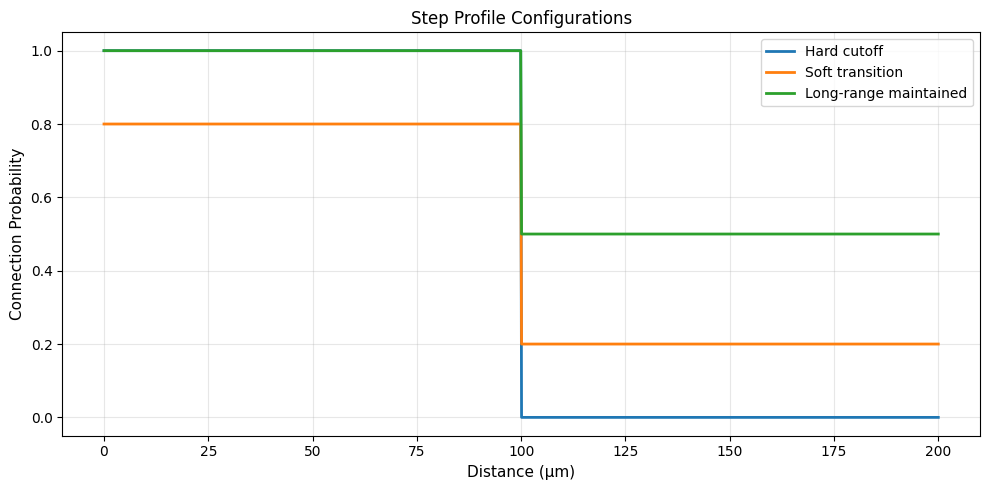

In [11]:
# Create Step profile
step = init.StepProfile(
    threshold=100.0 * u.um,
    inside_prob=0.9,
    outside_prob=0.1
)

visualize_profile(step, max_distance=200, title="Step Profile")

# Compare different step configurations
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(0, 200, 1000) * u.um

configs = [
    (100.0, 1.0, 0.0, 'Hard cutoff'),
    (100.0, 0.8, 0.2, 'Soft transition'),
    (100.0, 1.0, 0.5, 'Long-range maintained'),
]

for threshold, p_in, p_out, label in configs:
    profile = init.StepProfile(threshold * u.um, p_in, p_out)
    probs = profile.probability(distances)
    ax.plot(distances.mantissa, probs, linewidth=2, label=label)

ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Connection Probability', fontsize=11)
ax.set_title('Step Profile Configurations', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Advanced Distance Profiles

### 3.1 Sigmoid Profile

The **Sigmoid profile** creates smooth S-shaped transitions:

$$p(d) = \frac{1}{1 + e^{k(d - d_0)}}$$

**Parameters:**
- `midpoint`: Distance at which probability is 0.5
- `slope`: Steepness of transition
- `max_distance`: Optional cutoff

**Use cases:**
- Smooth transitions
- Threshold-like behavior
- Gradual connectivity changes

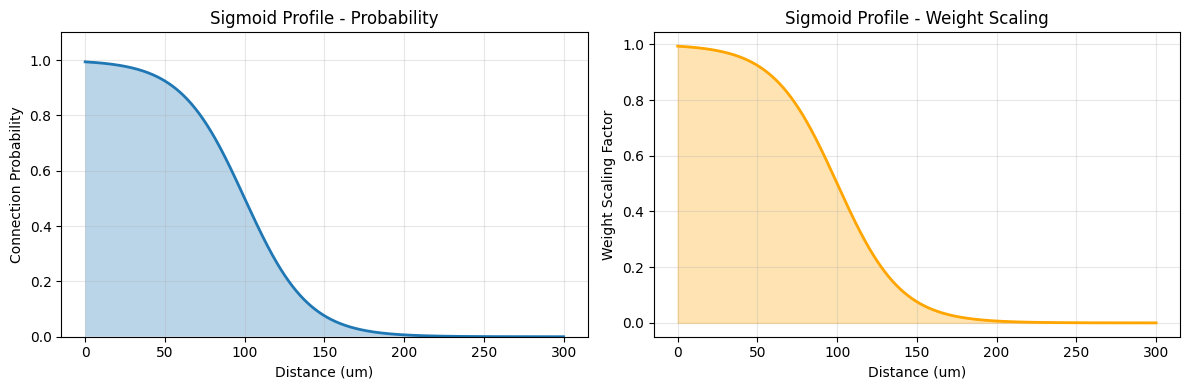

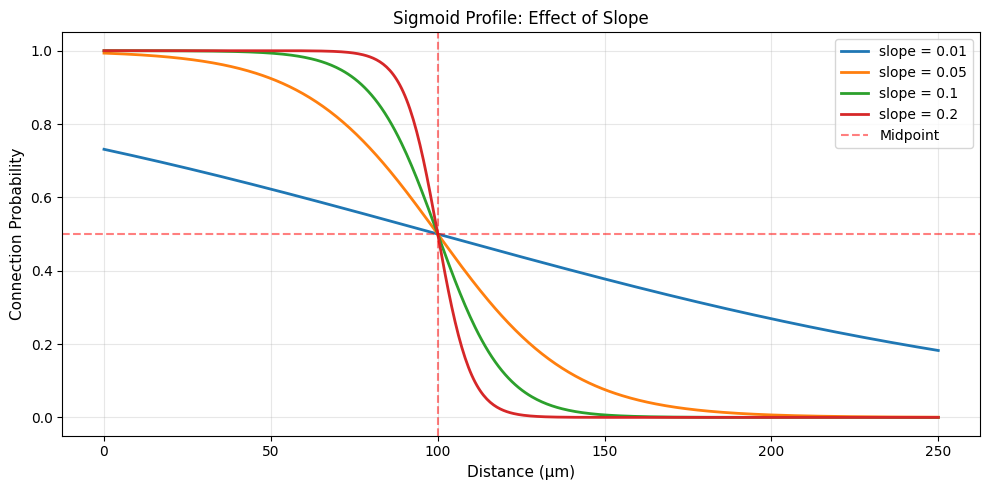


💡 Larger slope → sharper transition (approaches step function)


In [12]:
# Create Sigmoid profile
sigmoid = init.SigmoidProfile(
    midpoint=100.0 * u.um,
    slope=0.05,
    max_distance=300.0 * u.um
)

visualize_profile(sigmoid, max_distance=300, title="Sigmoid Profile")

# Compare different slopes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(0, 250, 500) * u.um
slopes = [0.01, 0.05, 0.1, 0.2]

for slope in slopes:
    profile = init.SigmoidProfile(midpoint=100.0 * u.um, slope=slope)
    probs = profile.probability(distances)
    ax.plot(distances.mantissa, probs, linewidth=2, label=f'slope = {slope}')

ax.axvline(100, color='red', linestyle='--', alpha=0.5, label='Midpoint')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Connection Probability', fontsize=11)
ax.set_title('Sigmoid Profile: Effect of Slope', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Larger slope → sharper transition (approaches step function)")

### 3.2 Difference of Gaussians (DoG) Profile

The **DoG profile** creates center-surround patterns:

$$p(d) = A_c e^{-\frac{d^2}{2\sigma_c^2}} - A_s e^{-\frac{d^2}{2\sigma_s^2}}$$

**Parameters:**
- `sigma_center`: Center Gaussian width
- `sigma_surround`: Surround Gaussian width (> sigma_center)
- `amplitude_center`: Center amplitude
- `amplitude_surround`: Surround amplitude

**Use cases:**
- **Lateral inhibition**
- Center-surround receptive fields
- Competitive dynamics

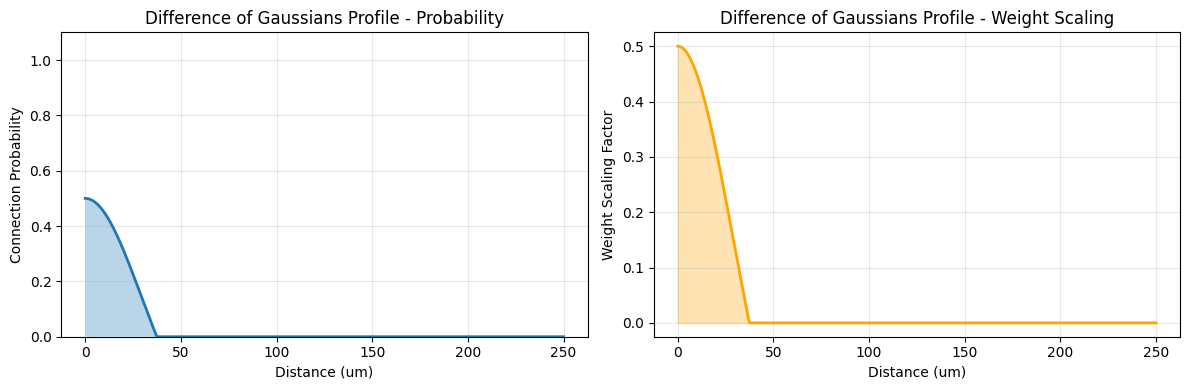

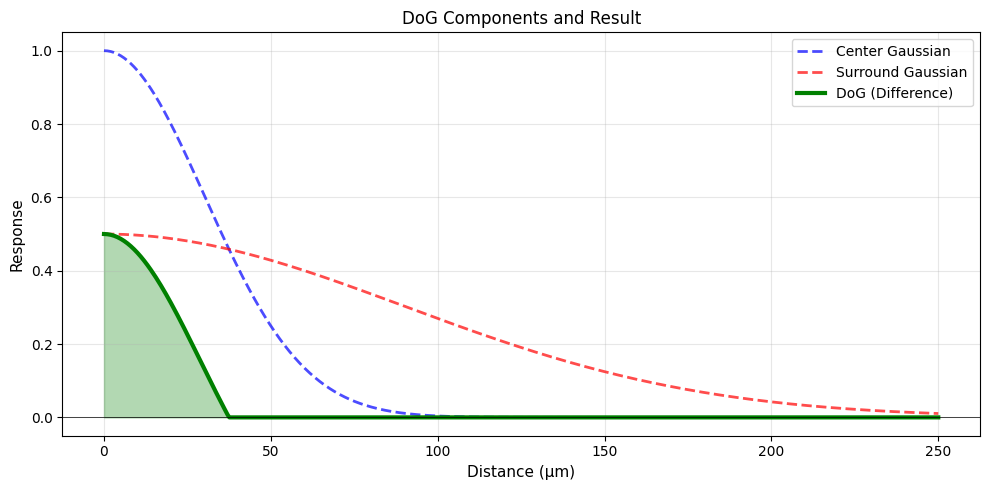


🧠 DoG creates lateral inhibition:
  - Strong excitation at center
  - Inhibition at intermediate distances
  - Common in visual cortex receptive fields


In [13]:
# Create DoG profile
dog = init.DoGProfile(
    sigma_center=30.0 * u.um,
    sigma_surround=90.0 * u.um,
    amplitude_center=1.0,
    amplitude_surround=0.5,
    max_distance=250.0 * u.um
)

visualize_profile(dog, max_distance=250, title="Difference of Gaussians Profile")

# Visualize components
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(0, 250, 500) * u.um

# Components
center_gaussian = init.GaussianProfile(sigma=30.0 * u.um)
surround_gaussian = init.GaussianProfile(sigma=90.0 * u.um)

center = center_gaussian.probability(distances)
surround = 0.5 * surround_gaussian.probability(distances)
dog_result = dog.probability(distances)

ax.plot(distances.mantissa, center, 'b--', linewidth=2, label='Center Gaussian', alpha=0.7)
ax.plot(distances.mantissa, surround, 'r--', linewidth=2, label='Surround Gaussian', alpha=0.7)
ax.plot(distances.mantissa, dog_result, 'g-', linewidth=3, label='DoG (Difference)')
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.fill_between(distances.mantissa, 0, dog_result, alpha=0.3, color='green')

ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Response', fontsize=11)
ax.set_title('DoG Components and Result', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🧠 DoG creates lateral inhibition:")
print("  - Strong excitation at center")
print("  - Inhibition at intermediate distances")
print("  - Common in visual cortex receptive fields")

### 3.3 Mexican Hat Profile

The **Mexican Hat profile** is the second derivative of a Gaussian:

$$p(d) = A \cdot \left(1 - \frac{d^2}{\sigma^2}\right) e^{-\frac{d^2}{2\sigma^2}}$$

**Parameters:**
- `sigma`: Width parameter
- `amplitude`: Scaling factor
- `max_distance`: Optional cutoff

**Use cases:**
- Center-surround patterns
- Lateral inhibition
- Self-organizing maps

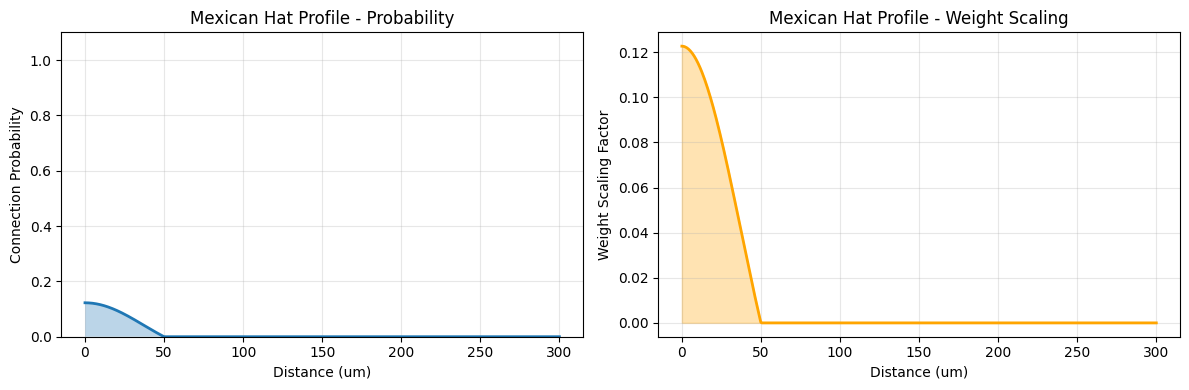

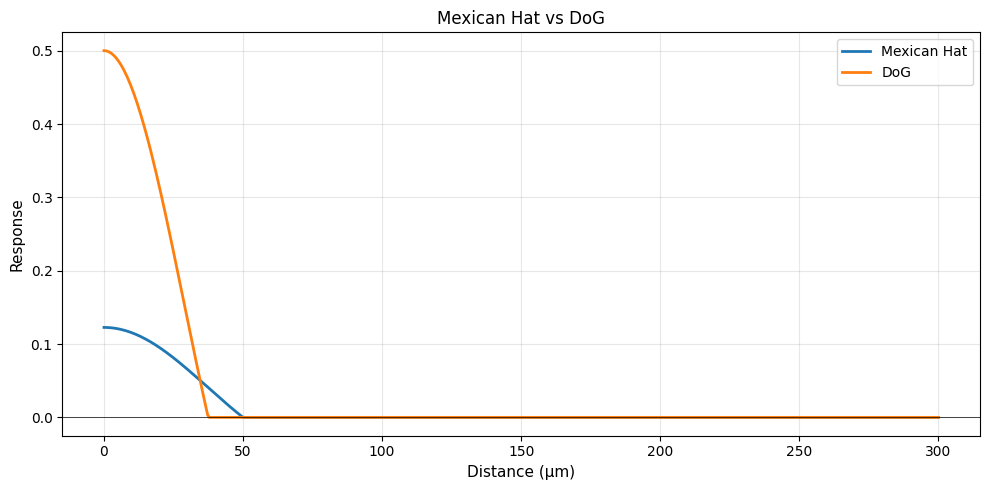


📊 Mexican Hat properties:
  - Single parameter (sigma) controls shape
  - More regular than DoG
  - Ricker wavelet in signal processing


In [14]:
# Create Mexican Hat profile
mexican_hat = init.MexicanHatProfile(
    sigma=50.0 * u.um,
    amplitude=1.0,
    max_distance=300.0 * u.um
)

visualize_profile(mexican_hat, max_distance=300, title="Mexican Hat Profile")

# Compare with DoG
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(0, 300, 500) * u.um

mh_profile = init.MexicanHatProfile(sigma=50.0 * u.um)
dog_profile = init.DoGProfile(sigma_center=30.0 * u.um, sigma_surround=90.0 * u.um)

mh_prob = mh_profile.probability(distances)
dog_prob = dog_profile.probability(distances)

ax.plot(distances.mantissa, mh_prob, linewidth=2, label='Mexican Hat')
ax.plot(distances.mantissa, dog_prob, linewidth=2, label='DoG')
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Response', fontsize=11)
ax.set_title('Mexican Hat vs DoG', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Mexican Hat properties:")
print("  - Single parameter (sigma) controls shape")
print("  - More regular than DoG")
print("  - Ricker wavelet in signal processing")

### 3.4 Bimodal Profile

The **Bimodal profile** has two peaks:

$$p(d) = A_1 e^{-\frac{(d-c_1)^2}{2\sigma_1^2}} + A_2 e^{-\frac{(d-c_2)^2}{2\sigma_2^2}}$$

**Parameters:**
- `sigma1`, `sigma2`: Widths of two peaks
- `center1`, `center2`: Locations of peaks
- `amplitude1`, `amplitude2`: Heights of peaks

**Use cases:**
- Local + long-range connections
- Multi-scale connectivity
- Hierarchical networks

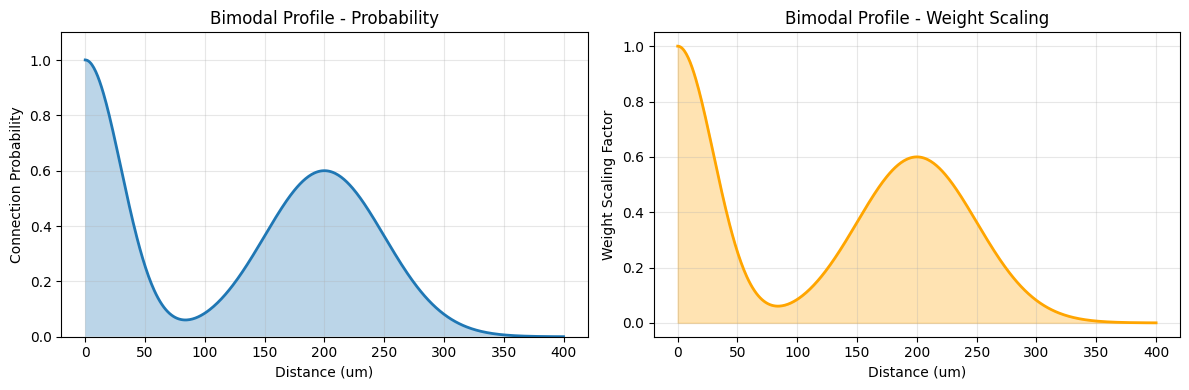

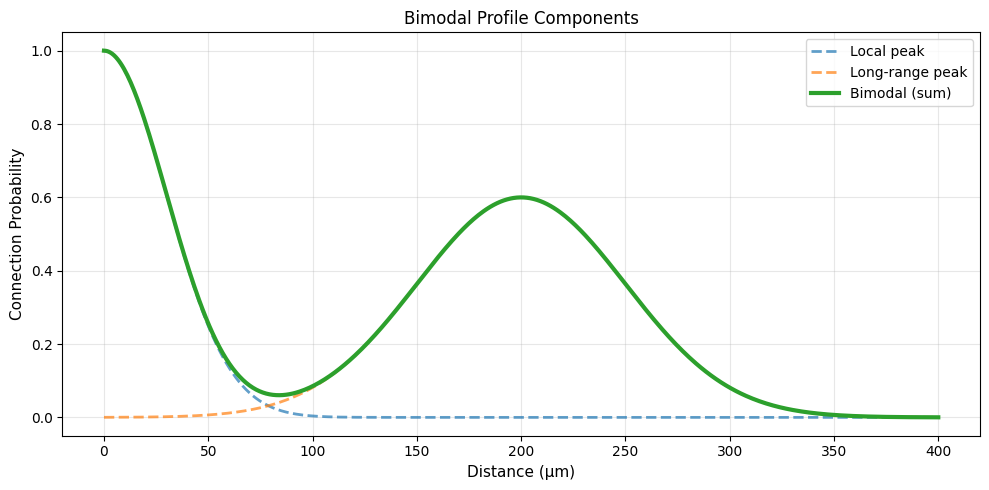


🔗 Bimodal connectivity:
  - Local connections (first peak)
  - Long-range connections (second peak)
  - Common in cortical circuits


In [15]:
# Create Bimodal profile
bimodal = init.BimodalProfile(
    sigma1=30.0 * u.um,
    sigma2=50.0 * u.um,
    center1=0.0 * u.um,
    center2=200.0 * u.um,
    amplitude1=1.0,
    amplitude2=0.6,
    max_distance=400.0 * u.um
)

visualize_profile(bimodal, max_distance=400, title="Bimodal Profile")

# Show components
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

distances = np.linspace(0, 400, 500) * u.um

# Individual Gaussians
gauss1 = init.GaussianProfile(sigma=30.0 * u.um)
gauss2 = init.GaussianProfile(sigma=50.0 * u.um)

prob1 = gauss1.probability(distances)
prob2 = 0.6 * gauss2.probability(distances - 200.0 * u.um + distances[0])
bimodal_prob = bimodal.probability(distances)

ax.plot(distances.mantissa, prob1, '--', linewidth=2, label='Local peak', alpha=0.7)
ax.plot(distances.mantissa, prob2, '--', linewidth=2, label='Long-range peak', alpha=0.7)
ax.plot(distances.mantissa, bimodal_prob, linewidth=3, label='Bimodal (sum)')

ax.set_xlabel('Distance (μm)', fontsize=11)
ax.set_ylabel('Connection Probability', fontsize=11)
ax.set_title('Bimodal Profile Components', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔗 Bimodal connectivity:")
print("  - Local connections (first peak)")
print("  - Long-range connections (second peak)")
print("  - Common in cortical circuits")

### 3.5 Logistic Profile

The **Logistic profile** is similar to sigmoid:

$$p(d) = \frac{1}{1 + e^{k(d - d_0)}}$$

**Parameters:**
- `growth_rate`: Controls decay speed
- `midpoint`: Half-probability distance

**Use cases:**
- Growth-like patterns
- Smooth transitions
- Similar to sigmoid

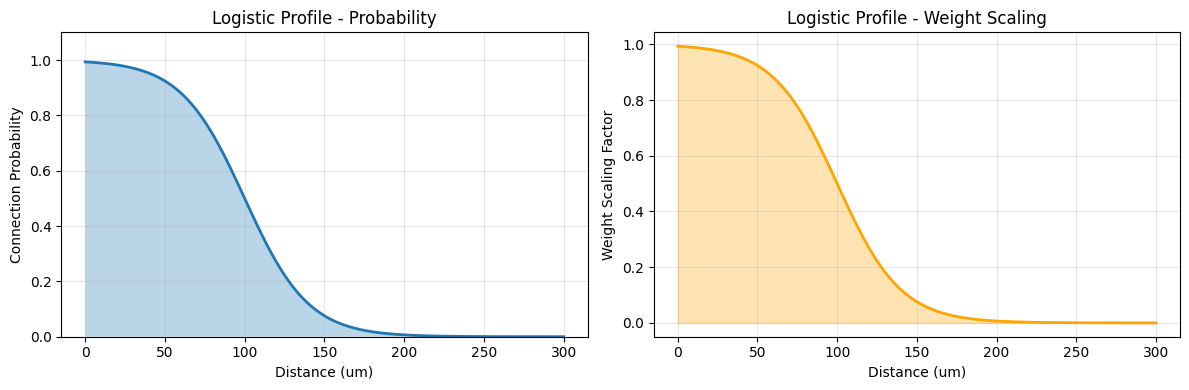

(ArrayImpl([  0.       ,   0.60120243,   1.20240486,   1.80360723,
              2.40480971,   3.00601... * umetre,
 array([9.93307149e-01, 9.93104315e-01, 9.92895378e-01, 9.92680157e-01,
        9.92458466e-01, 9.92230113e-01, 9.91994901e-01, 9.91752628e-01,
        9.91503086e-01, 9.91246060e-01, 9.90981330e-01, 9.90708669e-01,
        9.90427844e-01, 9.90138616e-01, 9.89840739e-01, 9.89533958e-01,
        9.89218015e-01, 9.88892641e-01, 9.88557562e-01, 9.88212495e-01,
        9.87857150e-01, 9.87491228e-01, 9.87114423e-01, 9.86726420e-01,
        9.86326896e-01, 9.85915517e-01, 9.85491944e-01, 9.85055825e-01,
        9.84606802e-01, 9.84144503e-01, 9.83668551e-01, 9.83178556e-01,
        9.82674119e-01, 9.82154829e-01, 9.81620266e-01, 9.81069999e-01,
        9.80503584e-01, 9.79920569e-01, 9.79320487e-01, 9.78702860e-01,
        9.78067201e-01, 9.77413007e-01, 9.76739764e-01, 9.76046945e-01,
        9.75334012e-01, 9.74600412e-01, 9.73845578e-01, 9.73068932e-01,
        9.72269880e-

In [16]:
# Create Logistic profile
logistic = init.LogisticProfile(
    growth_rate=0.05,
    midpoint=100.0 * u.um,
    max_distance=300.0 * u.um
)

visualize_profile(logistic, max_distance=300, title="Logistic Profile")

## 4. Profile Composition

One of the most powerful features of distance profiles is the ability to **compose** them using arithmetic operations and transformations.

### 4.1 Arithmetic Operations

Profiles support standard arithmetic operations:
- **Addition** (`+`): Combine connectivity patterns
- **Subtraction** (`-`): Create inhibitory patterns
- **Multiplication** (`*`): Scale or modulate
- **Division** (`/`): Normalize or ratio

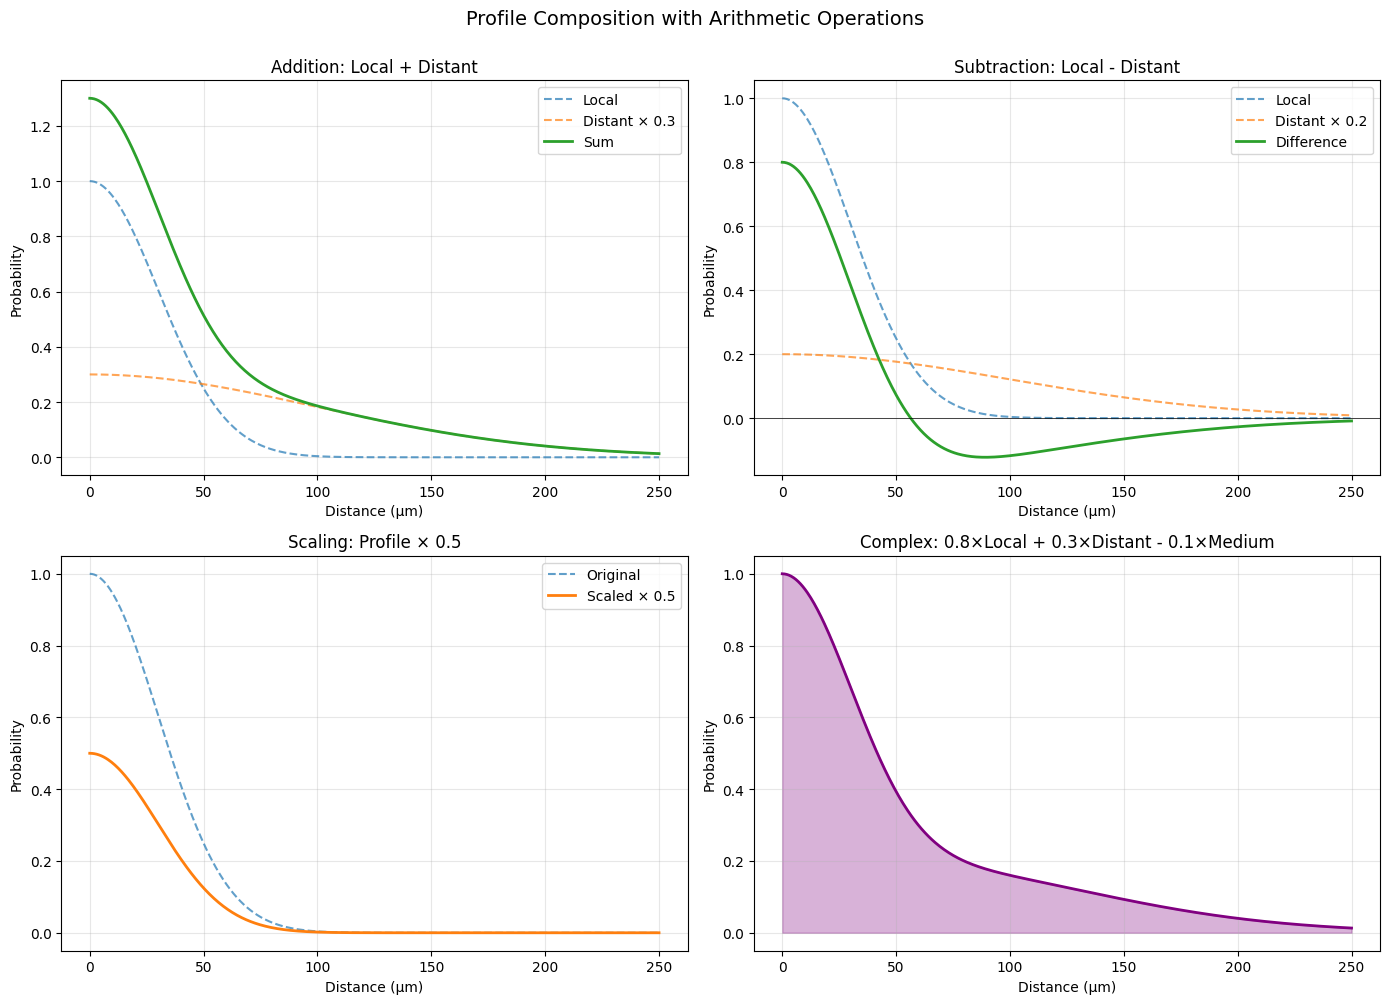


✨ Arithmetic operations enable complex connectivity patterns!


In [17]:
# Create base profiles
local = init.GaussianProfile(sigma=30.0 * u.um)
distant = init.GaussianProfile(sigma=100.0 * u.um)

# Compose profiles
combined_add = local + distant * 0.3
combined_sub = local - distant * 0.2
scaled = local * 0.5

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

distances = np.linspace(0, 250, 500) * u.um

# Addition
prob_local = local.probability(distances)
prob_distant = distant.probability(distances)
prob_add = combined_add.probability(distances)

axes[0].plot(distances.mantissa, prob_local, '--', label='Local', alpha=0.7)
axes[0].plot(distances.mantissa, prob_distant * 0.3, '--', label='Distant × 0.3', alpha=0.7)
axes[0].plot(distances.mantissa, prob_add, linewidth=2, label='Sum')
axes[0].set_title('Addition: Local + Distant')
axes[0].set_xlabel('Distance (μm)')
axes[0].set_ylabel('Probability')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Subtraction
prob_sub = combined_sub.probability(distances)
axes[1].plot(distances.mantissa, prob_local, '--', label='Local', alpha=0.7)
axes[1].plot(distances.mantissa, prob_distant * 0.2, '--', label='Distant × 0.2', alpha=0.7)
axes[1].plot(distances.mantissa, prob_sub, linewidth=2, label='Difference')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Subtraction: Local - Distant')
axes[1].set_xlabel('Distance (μm)')
axes[1].set_ylabel('Probability')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Scaling
prob_scaled = scaled.probability(distances)
axes[2].plot(distances.mantissa, prob_local, '--', label='Original', alpha=0.7)
axes[2].plot(distances.mantissa, prob_scaled, linewidth=2, label='Scaled × 0.5')
axes[2].set_title('Scaling: Profile × 0.5')
axes[2].set_xlabel('Distance (μm)')
axes[2].set_ylabel('Probability')
axes[2].legend()
axes[2].grid(alpha=0.3)

# Complex composition
complex_profile = (local * 0.8) + (distant * 0.3) - (init.GaussianProfile(sigma=60.0 * u.um) * 0.1)
prob_complex = complex_profile.probability(distances)
axes[3].plot(distances.mantissa, prob_complex, linewidth=2, color='purple')
axes[3].fill_between(distances.mantissa, prob_complex, alpha=0.3, color='purple')
axes[3].set_title('Complex: 0.8×Local + 0.3×Distant - 0.1×Medium')
axes[3].set_xlabel('Distance (μm)')
axes[3].set_ylabel('Probability')
axes[3].grid(alpha=0.3)

plt.suptitle('Profile Composition with Arithmetic Operations', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n✨ Arithmetic operations enable complex connectivity patterns!")

### 4.2 Clipping Transformations

The `.clip()` method bounds profile values:

```python
clipped = profile.clip(min_val=0.1, max_val=0.9)
```

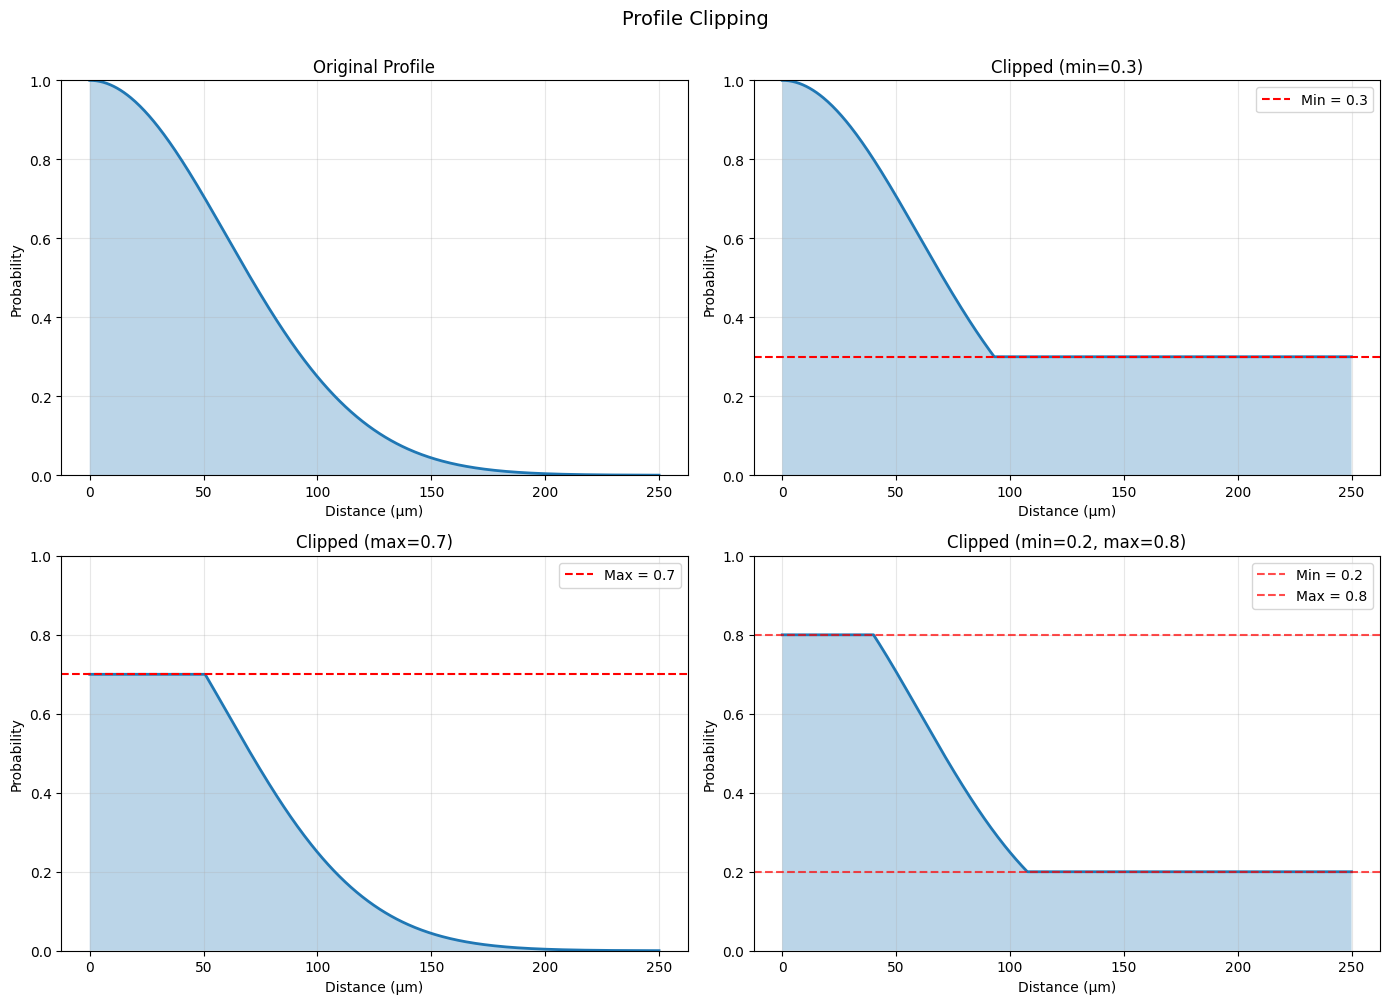


✂️ Clipping use cases:
  - Ensure minimum connectivity
  - Cap maximum connection strength
  - Create plateaus in connectivity


In [18]:
# Create profile and apply clipping
original = init.GaussianProfile(sigma=60.0 * u.um)
clipped_min = original.clip(min_val=0.3, max_val=None)
clipped_max = original.clip(min_val=None, max_val=0.7)
clipped_both = original.clip(min_val=0.2, max_val=0.8)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

distances = np.linspace(0, 250, 500) * u.um

# Original
prob_original = original.probability(distances)
axes[0].plot(distances.mantissa, prob_original, linewidth=2)
axes[0].fill_between(distances.mantissa, prob_original, alpha=0.3)
axes[0].set_title('Original Profile')
axes[0].set_xlabel('Distance (μm)')
axes[0].set_ylabel('Probability')
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

# Clipped min
prob_min = clipped_min.probability(distances)
axes[1].plot(distances.mantissa, prob_min, linewidth=2)
axes[1].fill_between(distances.mantissa, prob_min, alpha=0.3)
axes[1].axhline(0.3, color='red', linestyle='--', label='Min = 0.3')
axes[1].set_title('Clipped (min=0.3)')
axes[1].set_xlabel('Distance (μm)')
axes[1].set_ylabel('Probability')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])

# Clipped max
prob_max = clipped_max.probability(distances)
axes[2].plot(distances.mantissa, prob_max, linewidth=2)
axes[2].fill_between(distances.mantissa, prob_max, alpha=0.3)
axes[2].axhline(0.7, color='red', linestyle='--', label='Max = 0.7')
axes[2].set_title('Clipped (max=0.7)')
axes[2].set_xlabel('Distance (μm)')
axes[2].set_ylabel('Probability')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0, 1])

# Clipped both
prob_both = clipped_both.probability(distances)
axes[3].plot(distances.mantissa, prob_both, linewidth=2)
axes[3].fill_between(distances.mantissa, prob_both, alpha=0.3)
axes[3].axhline(0.2, color='red', linestyle='--', alpha=0.7, label='Min = 0.2')
axes[3].axhline(0.8, color='red', linestyle='--', alpha=0.7, label='Max = 0.8')
axes[3].set_title('Clipped (min=0.2, max=0.8)')
axes[3].set_xlabel('Distance (μm)')
axes[3].set_ylabel('Probability')
axes[3].legend()
axes[3].grid(alpha=0.3)
axes[3].set_ylim([0, 1])

plt.suptitle('Profile Clipping', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n✂️ Clipping use cases:")
print("  - Ensure minimum connectivity")
print("  - Cap maximum connection strength")
print("  - Create plateaus in connectivity")

### 4.3 Apply Transformations

The `.apply()` method applies arbitrary functions:

```python
transformed = profile.apply(lambda x: x ** 2)
```

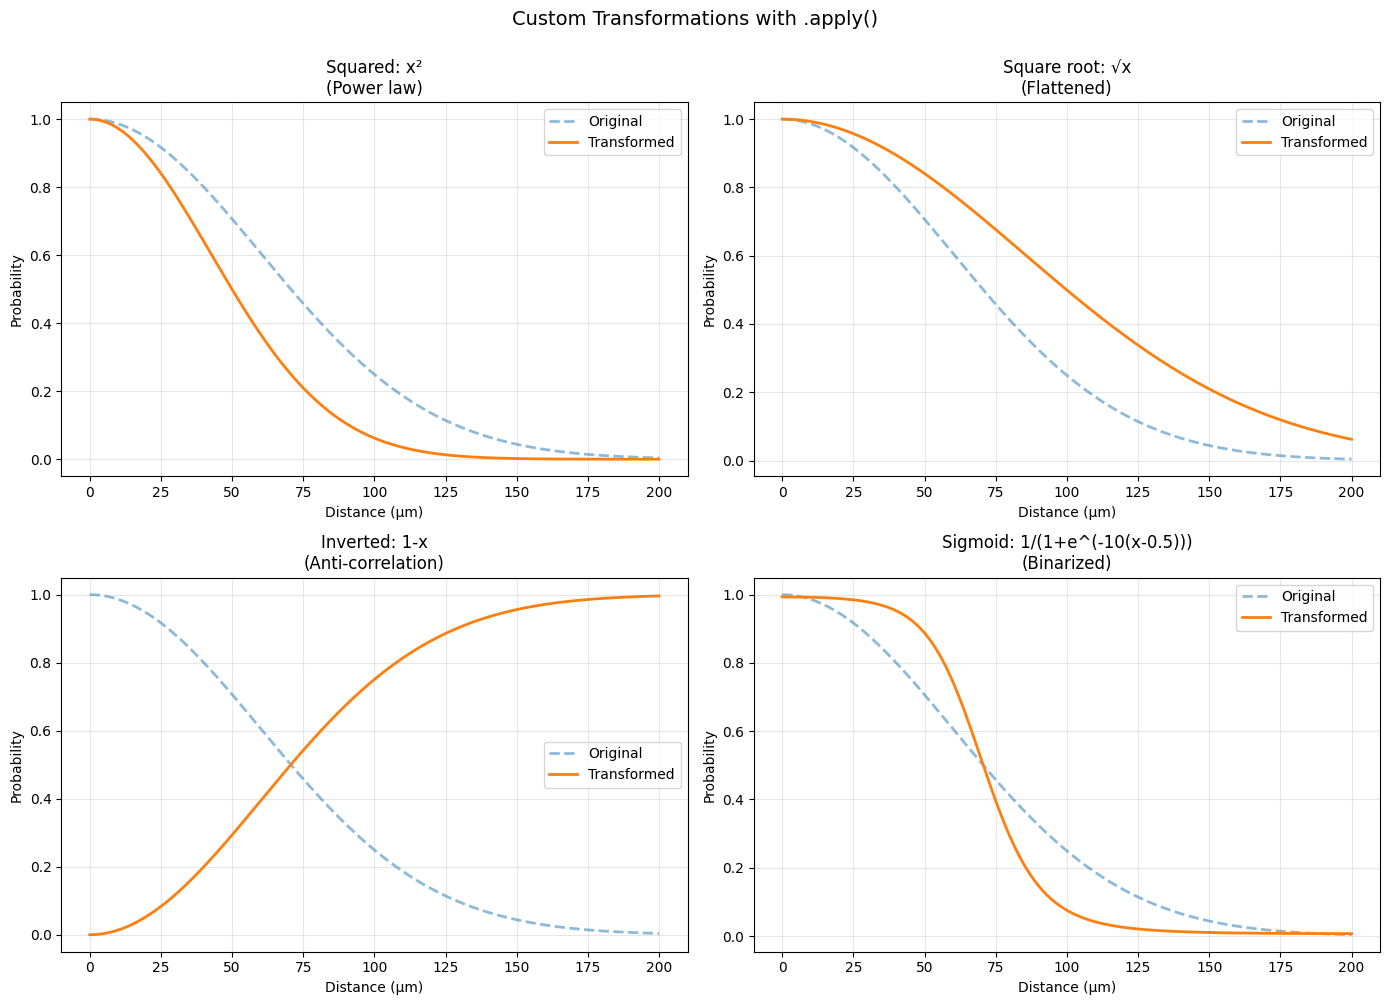


🔧 Transformation examples:
  x² → Emphasize strong connections
  √x → Flatten differences
  1-x → Create inhibitory pattern
  sigmoid → Binarize connectivity


In [19]:
# Create profile and apply transformations
base = init.GaussianProfile(sigma=60.0 * u.um)

# Different transformations
squared = base.apply(lambda x: x ** 2)
sqrt = base.apply(lambda x: np.sqrt(x))
inverted = base.apply(lambda x: 1 - x)
sigmoid_transform = base.apply(lambda x: 1 / (1 + np.exp(-10 * (x - 0.5))))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

distances = np.linspace(0, 200, 500) * u.um

profiles = [
    (squared, 'Squared: x²', 'Power law'),
    (sqrt, 'Square root: √x', 'Flattened'),
    (inverted, 'Inverted: 1-x', 'Anti-correlation'),
    (sigmoid_transform, 'Sigmoid: 1/(1+e^(-10(x-0.5)))', 'Binarized'),
]

for ax, (profile, title, desc) in zip(axes, profiles):
    prob_original = base.probability(distances)
    prob_transformed = profile.probability(distances)
    
    ax.plot(distances.mantissa, prob_original, '--', linewidth=2, 
            label='Original', alpha=0.5)
    ax.plot(distances.mantissa, prob_transformed, linewidth=2, label='Transformed')
    ax.set_title(f'{title}\n({desc})')
    ax.set_xlabel('Distance (μm)')
    ax.set_ylabel('Probability')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Custom Transformations with .apply()', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n🔧 Transformation examples:")
print("  x² → Emphasize strong connections")
print("  √x → Flatten differences")
print("  1-x → Create inhibitory pattern")
print("  sigmoid → Binarize connectivity")

### 4.4 Pipe Operator

The **pipe operator** (`|`) chains operations:

```python
result = profile | (lambda x: x * 2) | (lambda x: np.minimum(x, 1.0))
```

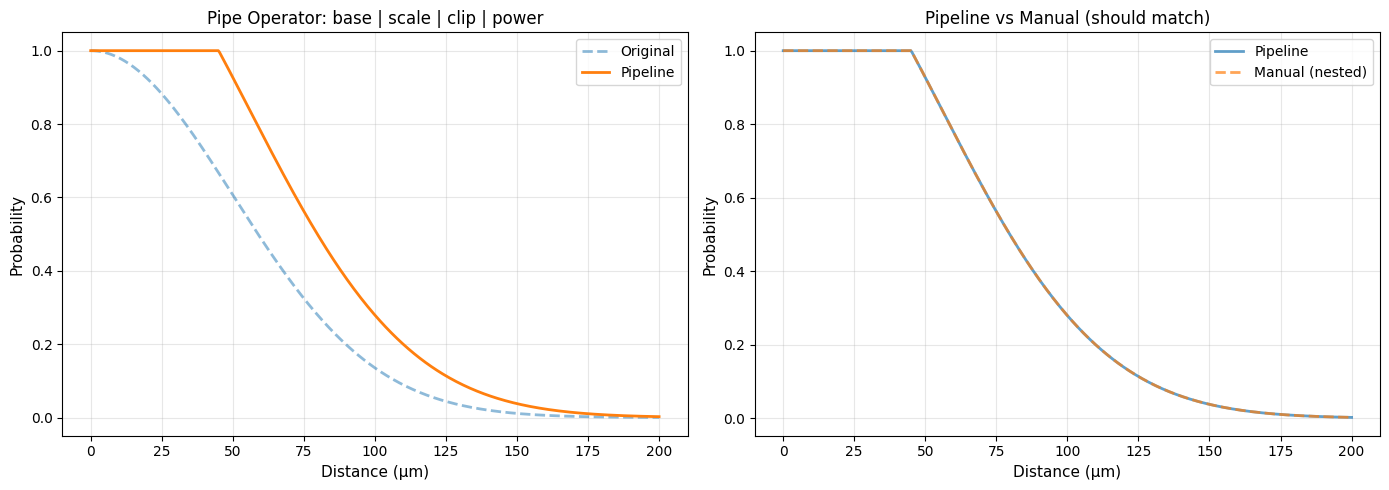


⛓️ Pipe operator benefits:
  ✓ More readable (left-to-right flow)
  ✓ Easier to modify pipeline
  ✓ Composable and modular

  Pipeline ≈ Manual: True


In [20]:
# Create a complex pipeline
base = init.GaussianProfile(sigma=50.0 * u.um)

# Chain operations with pipe operator
pipeline = (
    base 
    | (lambda x: x * 1.5)           # Scale up
    | (lambda x: np.minimum(x, 1.0)) # Clip to max 1
    | (lambda x: x ** 0.8)           # Slight power transform
)

# Alternative: without pipe operator (nested)
manual = base.apply(lambda x: (np.minimum(x * 1.5, 1.0)) ** 0.8)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

distances = np.linspace(0, 200, 500) * u.um

prob_base = base.probability(distances)
prob_pipeline = pipeline.probability(distances)
prob_manual = manual.probability(distances)

# Pipeline result
axes[0].plot(distances.mantissa, prob_base, '--', linewidth=2, label='Original', alpha=0.5)
axes[0].plot(distances.mantissa, prob_pipeline, linewidth=2, label='Pipeline')
axes[0].set_xlabel('Distance (μm)', fontsize=11)
axes[0].set_ylabel('Probability', fontsize=11)
axes[0].set_title('Pipe Operator: base | scale | clip | power', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Verify equivalence
axes[1].plot(distances.mantissa, prob_pipeline, linewidth=2, label='Pipeline', alpha=0.7)
axes[1].plot(distances.mantissa, prob_manual, '--', linewidth=2, label='Manual (nested)', alpha=0.7)
axes[1].set_xlabel('Distance (μm)', fontsize=11)
axes[1].set_ylabel('Probability', fontsize=11)
axes[1].set_title('Pipeline vs Manual (should match)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⛓️ Pipe operator benefits:")
print("  ✓ More readable (left-to-right flow)")
print("  ✓ Easier to modify pipeline")
print("  ✓ Composable and modular")
print(f"\n  Pipeline ≈ Manual: {np.allclose(prob_pipeline, prob_manual)}")

### Complex Composition Example

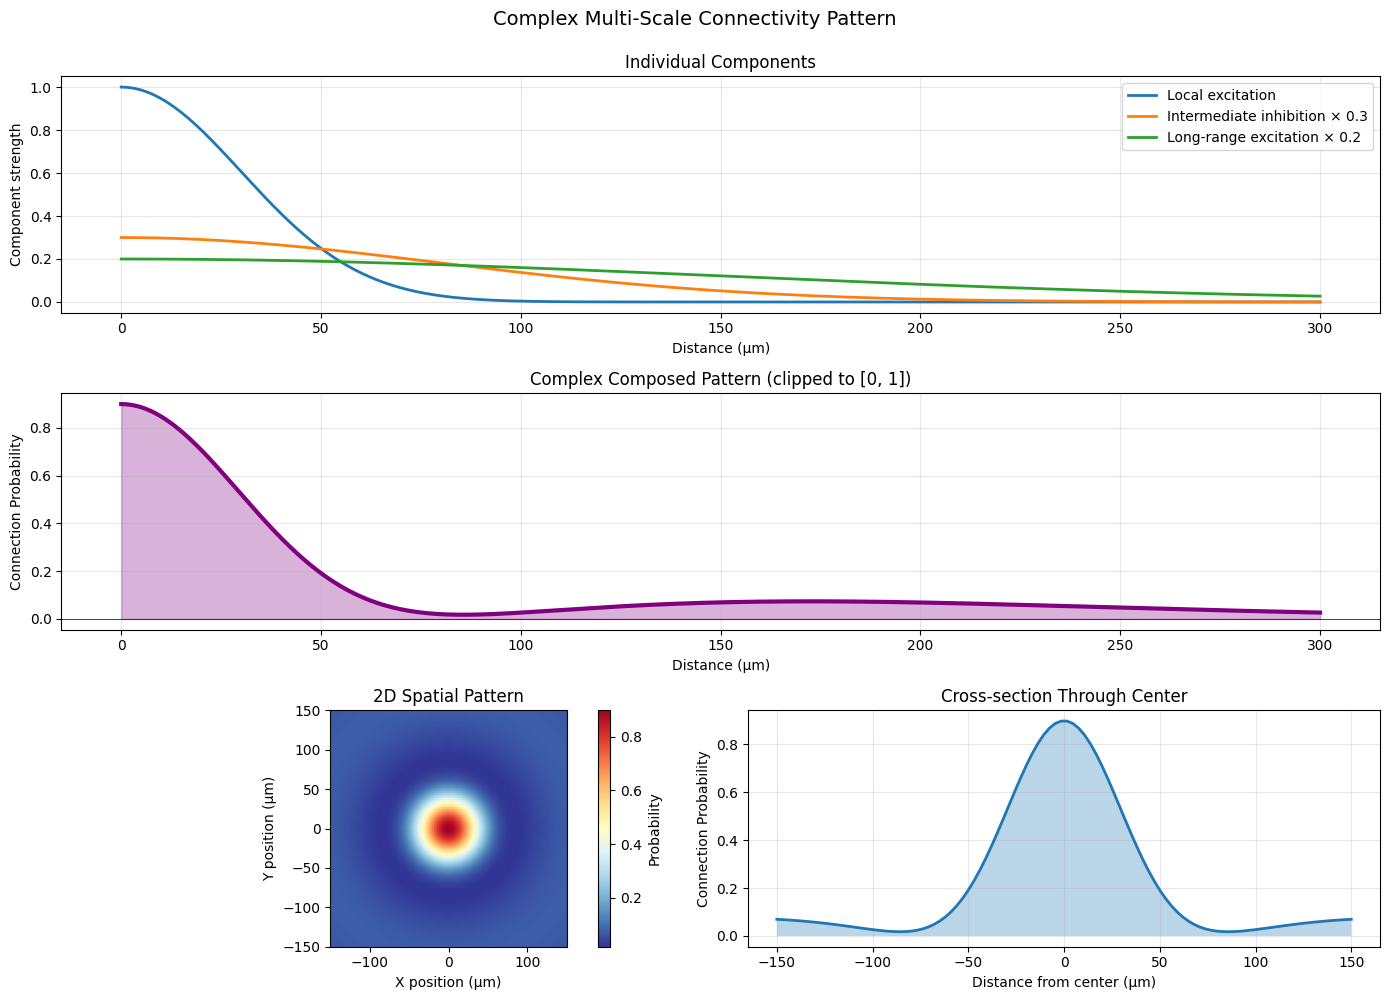


🧠 This pattern creates:
  1. Strong local excitation (0-50 μm)
  2. Lateral inhibition (50-150 μm)
  3. Weak long-range excitation (150-300 μm)

  Common in cortical circuits!


In [21]:
# Build a complex connectivity pattern
# Goal: Strong local, weak intermediate, moderate long-range

local_excitation = init.GaussianProfile(sigma=30.0 * u.um)
intermediate_inhibition = init.GaussianProfile(sigma=80.0 * u.um)
long_range_excitation = init.GaussianProfile(sigma=150.0 * u.um)

# Compose with weights
complex_pattern = (
    local_excitation * 1.0
    - intermediate_inhibition * 0.3
    + long_range_excitation * 0.2
).clip(min_val=0.0, max_val=1.0)

# Visualize
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(3, 2, figure=fig)

distances = np.linspace(0, 300, 500) * u.um

# Components
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(distances.mantissa, local_excitation.probability(distances), 
         label='Local excitation', linewidth=2)
ax1.plot(distances.mantissa, intermediate_inhibition.probability(distances) * 0.3, 
         label='Intermediate inhibition × 0.3', linewidth=2)
ax1.plot(distances.mantissa, long_range_excitation.probability(distances) * 0.2, 
         label='Long-range excitation × 0.2', linewidth=2)
ax1.set_xlabel('Distance (μm)')
ax1.set_ylabel('Component strength')
ax1.set_title('Individual Components')
ax1.legend()
ax1.grid(alpha=0.3)

# Composed pattern
ax2 = fig.add_subplot(gs[1, :])
prob_complex = complex_pattern.probability(distances)
ax2.plot(distances.mantissa, prob_complex, linewidth=3, color='purple')
ax2.fill_between(distances.mantissa, prob_complex, alpha=0.3, color='purple')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Distance (μm)')
ax2.set_ylabel('Connection Probability')
ax2.set_title('Complex Composed Pattern (clipped to [0, 1])')
ax2.grid(alpha=0.3)

# 2D visualization
ax3 = fig.add_subplot(gs[2, 0])
x = np.linspace(-150, 150, 100)
y = np.linspace(-150, 150, 100)
X, Y = np.meshgrid(x, y)
D = np.sqrt(X**2 + Y**2) * u.um
P = complex_pattern.probability(D)
im = ax3.imshow(P, extent=[-150, 150, -150, 150], origin='lower', cmap='RdYlBu_r')
ax3.set_xlabel('X position (μm)')
ax3.set_ylabel('Y position (μm)')
ax3.set_title('2D Spatial Pattern')
plt.colorbar(im, ax=ax3, label='Probability')

# Cross-section
ax4 = fig.add_subplot(gs[2, 1])
center_row = P[50, :]
ax4.plot(x, center_row, linewidth=2)
ax4.fill_between(x, center_row, alpha=0.3)
ax4.set_xlabel('Distance from center (μm)')
ax4.set_ylabel('Connection Probability')
ax4.set_title('Cross-section Through Center')
ax4.grid(alpha=0.3)

plt.suptitle('Complex Multi-Scale Connectivity Pattern', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("\n🧠 This pattern creates:")
print("  1. Strong local excitation (0-50 μm)")
print("  2. Lateral inhibition (50-150 μm)")
print("  3. Weak long-range excitation (150-300 μm)")
print("\n  Common in cortical circuits!")

## 5. Real-World Neuroscience Applications

### Application 1: V1 Orientation Columns

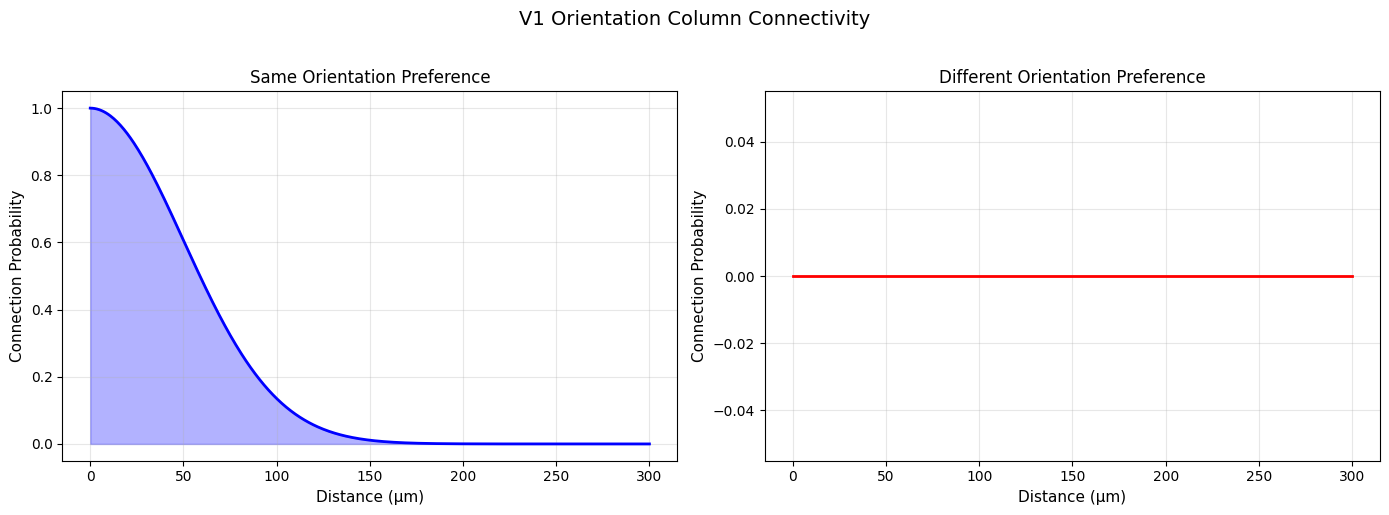


👁️ V1 orientation columns:
  - Neurons preferring same orientation connect strongly locally
  - Neurons with different orientations show lateral inhibition
  - Creates orientation selectivity sharpening


In [22]:
# Model V1 orientation column connectivity
# Same orientation: strong local connection
# Different orientation: lateral inhibition

# Simplified: distance-based approximation
same_orientation = init.GaussianProfile(sigma=50.0 * u.um)
different_orientation = (
    init.DoGProfile(
        sigma_center=40.0 * u.um,
        sigma_surround=100.0 * u.um,
        amplitude_center=0.3,
        amplitude_surround=0.4
    )
).clip(min_val=0.0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

distances = np.linspace(0, 300, 500) * u.um

# Same orientation
prob_same = same_orientation.probability(distances)
axes[0].plot(distances.mantissa, prob_same, linewidth=2, color='blue')
axes[0].fill_between(distances.mantissa, prob_same, alpha=0.3, color='blue')
axes[0].set_xlabel('Distance (μm)', fontsize=11)
axes[0].set_ylabel('Connection Probability', fontsize=11)
axes[0].set_title('Same Orientation Preference', fontsize=12)
axes[0].grid(alpha=0.3)

# Different orientation
prob_diff = different_orientation.probability(distances)
axes[1].plot(distances.mantissa, prob_diff, linewidth=2, color='red')
axes[1].fill_between(distances.mantissa, prob_diff, alpha=0.3, color='red')
axes[1].set_xlabel('Distance (μm)', fontsize=11)
axes[1].set_ylabel('Connection Probability', fontsize=11)
axes[1].set_title('Different Orientation Preference', fontsize=12)
axes[1].grid(alpha=0.3)

plt.suptitle('V1 Orientation Column Connectivity', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n👁️ V1 orientation columns:")
print("  - Neurons preferring same orientation connect strongly locally")
print("  - Neurons with different orientations show lateral inhibition")
print("  - Creates orientation selectivity sharpening")

### Application 2: Hippocampal Place Cells

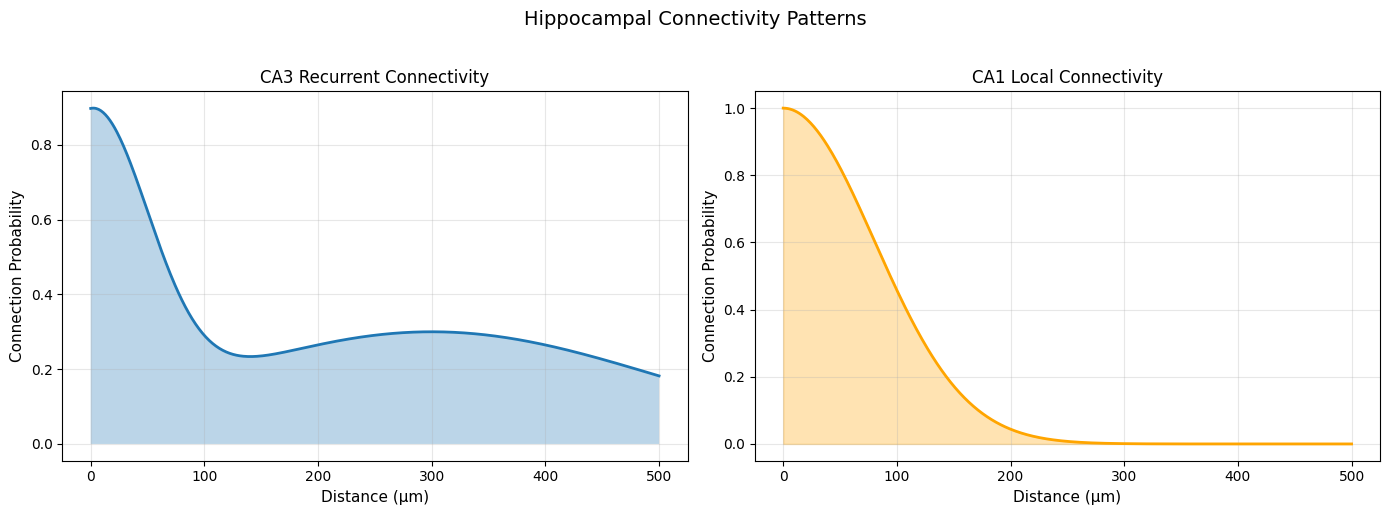


🧠 Hippocampal connectivity:
  CA3: Bimodal (supports pattern completion)
  CA1: More local (different computational role)
  Place cells with overlapping fields connect preferentially


In [23]:
# Hippocampal place cell connectivity
# Overlapping place fields → stronger connection

def place_field_overlap(distance, field_size=40.0):
    """
    Model place field overlap as function of cell distance.
    """
    # Simplified: Gaussian overlap
    profile = init.GaussianProfile(sigma=field_size * u.cm)
    return profile.probability(distance)

# CA3 recurrent connections: bimodal (local + long-range)
ca3_recurrent = init.BimodalProfile(
    sigma1=50.0 * u.um,
    sigma2=200.0 * u.um,
    center1=0.0 * u.um,
    center2=300.0 * u.um,
    amplitude1=0.8,
    amplitude2=0.3
)

# CA1 connections: more local
ca1_local = init.GaussianProfile(sigma=80.0 * u.um)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

distances = np.linspace(0, 500, 500) * u.um

# CA3 recurrent
prob_ca3 = ca3_recurrent.probability(distances)
axes[0].plot(distances.mantissa, prob_ca3, linewidth=2)
axes[0].fill_between(distances.mantissa, prob_ca3, alpha=0.3)
axes[0].set_xlabel('Distance (μm)', fontsize=11)
axes[0].set_ylabel('Connection Probability', fontsize=11)
axes[0].set_title('CA3 Recurrent Connectivity', fontsize=12)
axes[0].grid(alpha=0.3)

# CA1 local
prob_ca1 = ca1_local.probability(distances)
axes[1].plot(distances.mantissa, prob_ca1, linewidth=2, color='orange')
axes[1].fill_between(distances.mantissa, prob_ca1, alpha=0.3, color='orange')
axes[1].set_xlabel('Distance (μm)', fontsize=11)
axes[1].set_ylabel('Connection Probability', fontsize=11)
axes[1].set_title('CA1 Local Connectivity', fontsize=12)
axes[1].grid(alpha=0.3)

plt.suptitle('Hippocampal Connectivity Patterns', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n🧠 Hippocampal connectivity:")
print("  CA3: Bimodal (supports pattern completion)")
print("  CA1: More local (different computational role)")
print("  Place cells with overlapping fields connect preferentially")

### Application 3: Cortical Layer-Specific Connectivity

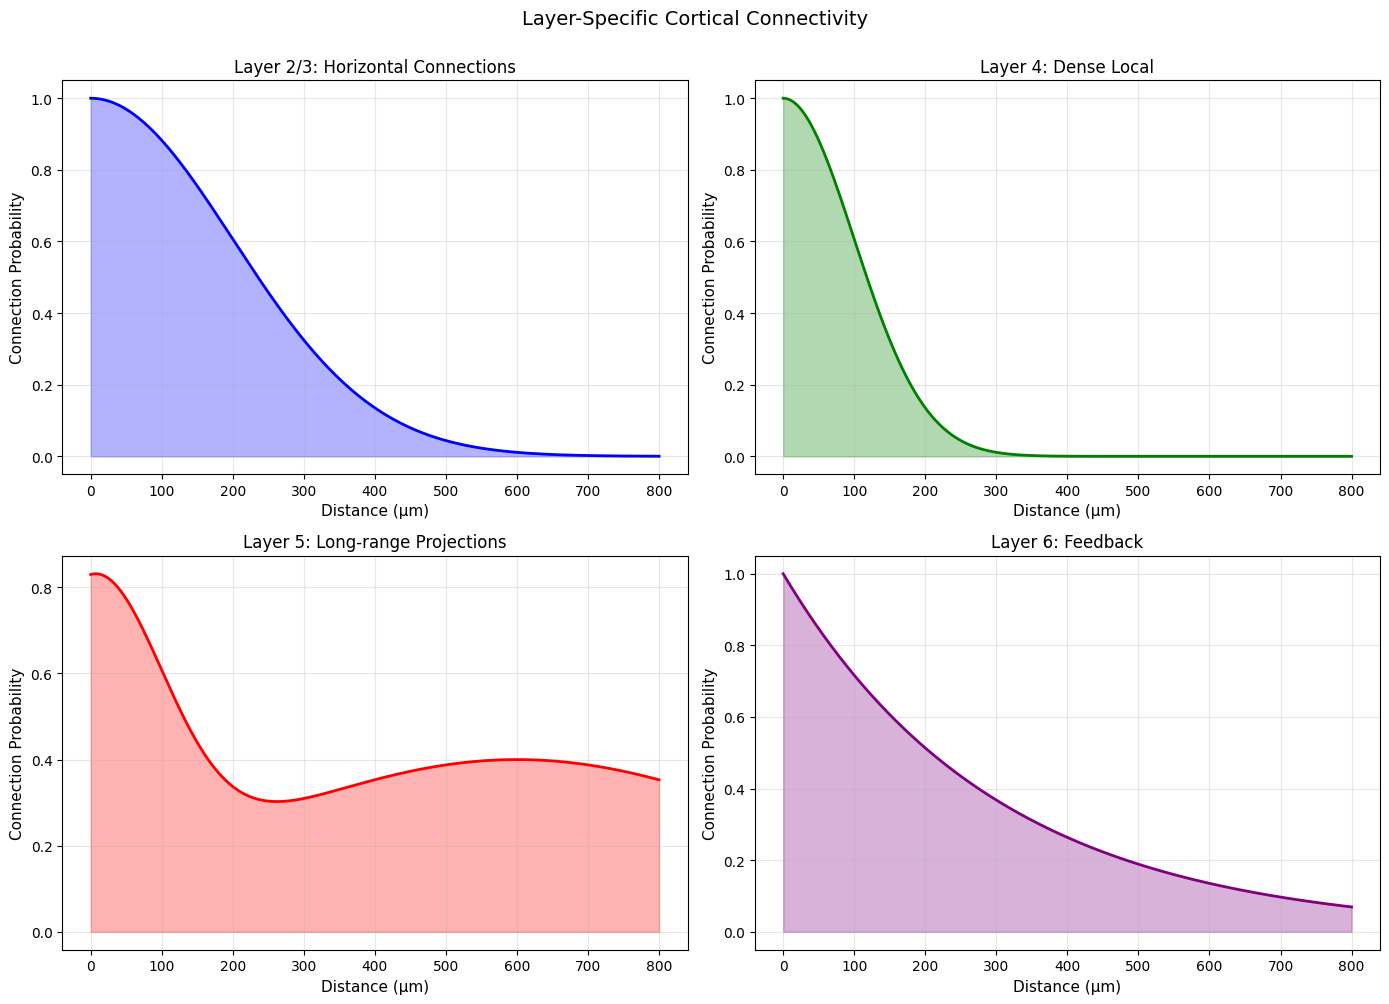


📊 Layer-specific properties:
  L2/3: Broad horizontal connections (integrate information)
  L4: Dense local (receive thalamic input)
  L5: Long-range projections (output layer)
  L6: Feedback to thalamus (modulation)


In [24]:
# Different cortical layers have different connectivity patterns

# Layer 2/3: Local horizontal connections
layer23 = init.GaussianProfile(sigma=200.0 * u.um)

# Layer 4: Dense local connections
layer4 = init.GaussianProfile(sigma=100.0 * u.um)

# Layer 5: Long-range projections
layer5 = init.BimodalProfile(
    sigma1=100.0 * u.um,
    sigma2=400.0 * u.um,
    center1=0.0 * u.um,
    center2=600.0 * u.um,
    amplitude1=0.7,
    amplitude2=0.4
)

# Layer 6: Feedback connections
layer6 = init.ExponentialProfile(decay_constant=300.0 * u.um)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

distances = np.linspace(0, 800, 500) * u.um

layers = [
    (layer23, 'Layer 2/3: Horizontal Connections', 'blue'),
    (layer4, 'Layer 4: Dense Local', 'green'),
    (layer5, 'Layer 5: Long-range Projections', 'red'),
    (layer6, 'Layer 6: Feedback', 'purple'),
]

for ax, (profile, title, color) in zip(axes, layers):
    prob = profile.probability(distances)
    ax.plot(distances.mantissa, prob, linewidth=2, color=color)
    ax.fill_between(distances.mantissa, prob, alpha=0.3, color=color)
    ax.set_xlabel('Distance (μm)', fontsize=11)
    ax.set_ylabel('Connection Probability', fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.grid(alpha=0.3)

plt.suptitle('Layer-Specific Cortical Connectivity', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n📊 Layer-specific properties:")
print("  L2/3: Broad horizontal connections (integrate information)")
print("  L4: Dense local (receive thalamic input)")
print("  L5: Long-range projections (output layer)")
print("  L6: Feedback to thalamus (modulation)")

## Summary

In this tutorial, we covered:

1. **Basic profiles**: Gaussian, Exponential, PowerLaw, Linear, Step
2. **Advanced profiles**: Sigmoid, DoG, Logistic, Bimodal, MexicanHat
3. **Profile composition**: Arithmetic operations, clipping, transformations
4. **Pipe operator**: Functional composition for clean code
5. **Real applications**: V1, hippocampus, cortical layers

### Profile Selection Guide:

| Pattern | Profile |
|---------|--------|
| Local excitation | Gaussian |
| Long-range decay | Exponential |
| Scale-free | PowerLaw |
| Hard boundary | Step, Linear |
| Smooth transition | Sigmoid, Logistic |
| Lateral inhibition | DoG, MexicanHat |
| Multi-scale | Bimodal, Composed |
